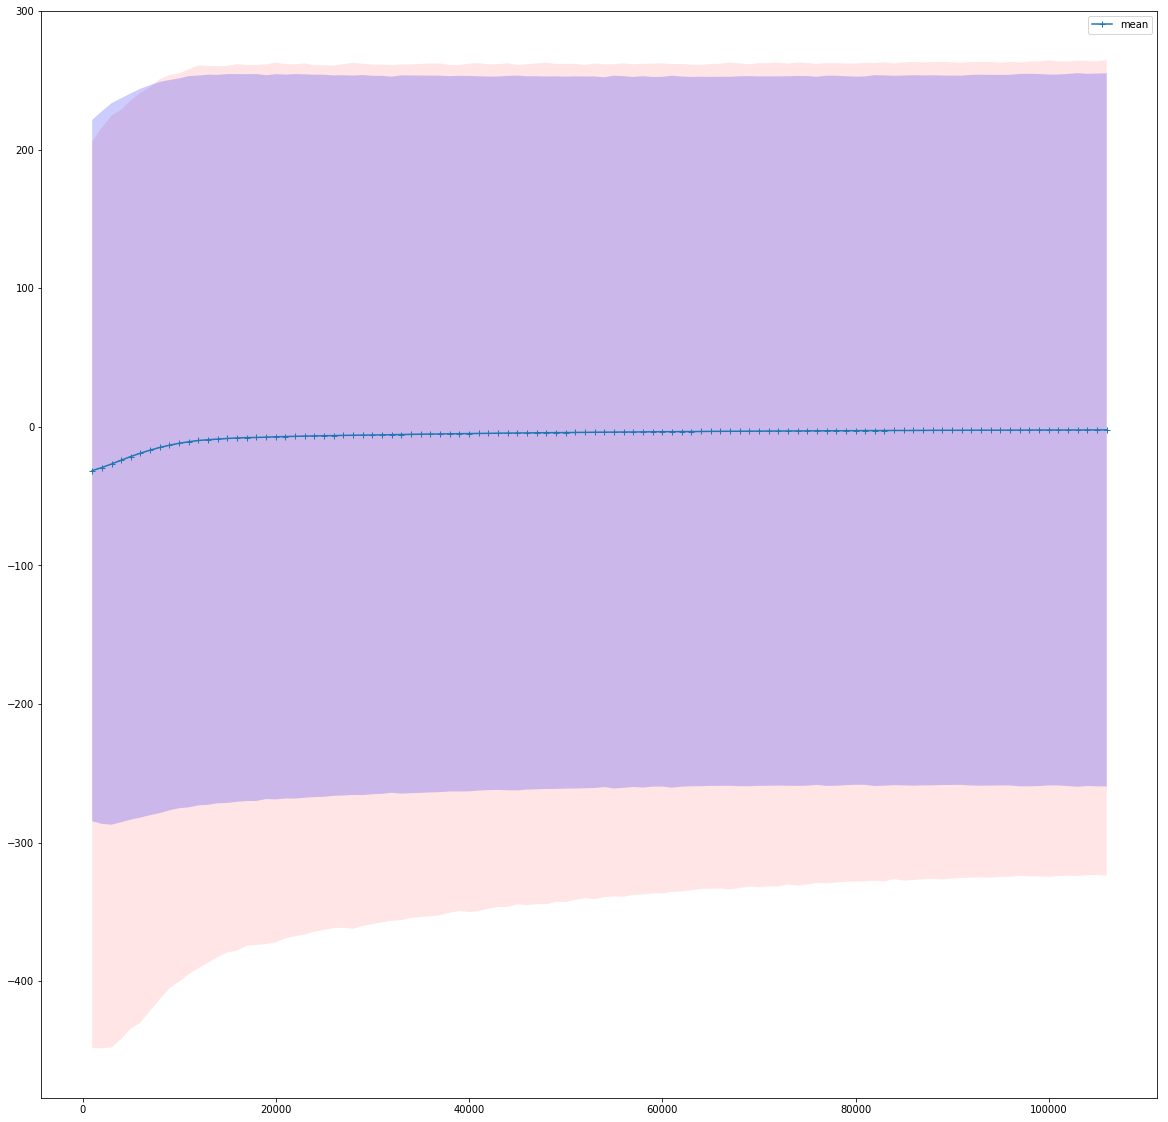

mean:-2.1730069050931515, std:257.2557380903607, max:264.6666688996311, min:-323.8037013731669
i:106000	src:Var([0.16 0.4 ])	true:Var([6.40733522])	pred:Var([6.42421517]), max_err:[0.00059069], mean_err:[7.5224369e-05]


In [ ]:
%matplotlib inline
"""
p.19-20
"""
import itertools
import random

import numpy
import numpy.random

import nn_functor.functions
import nn_functor.functions.error
from nn_functor.functions.sigmoid import sigmoid, sigmoid_derivative, sigmoid_derivative_n
import nn_functor.var
from nn_functor.report_simple import AggregateStore,PylabReporter
import nn_functor.var

agg = AggregateStore()

class L1Para(nn_functor.functions.Learn):
    def implement(self, a, p):
        """(p, a) -> b

        Parameters
        ----------
        a : tuple[numpy.array]
        p : tuple[numpy.array]

        Returns
        -------
        numpy.array
        """
        a = a[0]
        w00, w01, w10, b0, b1 = p

        return numpy.array([
            sigmoid(w00 * a[0] + w10 * a[1] + b0),
            sigmoid(w01 * a[0] + b1)
        ]).reshape(2)

    def update(self, a, b, p):
        """(p, a, b) -> p

        Parameters
        ----------
        a : tuple[numpy.array]
        b : numpy.array
        p : tuple[numpy.array]

        Returns
        -------
        tuple[numpy.array]
        """
        i = self.implement(a, p)

        a = a[0]
        w00, w01, w10, b0, b1 = p

        beta = [
            sigmoid_derivative(w00 * a[0] + w10 * a[1] + b0),
            sigmoid_derivative(w01 * a[0] + b1)
        ]

        return (
            w00 - self.eps * (i[0] - b[0]) * beta[0] * a[0],
            w01 - self.eps * (i[1] - b[1]) * beta[1] * a[0],
            w10 - self.eps * (i[0] - b[0]) * beta[0] * a[1],
            b0 - self.eps * (i[0] - b[0]) * beta[0],
            b1 - self.eps * (i[1] - b[1]) * beta[1],
        )

    def request(self, a, b, p):
        """(p, a, b) -> a

        Parameters
        ----------
        a: tuple[numpy.array]
        b: numpy.array
        p: tuple[numpy.array]

        Returns
        -------
        tuple[numpy.array]
        """
        i = self.implement(a, p)

        a = a[0]
        w00, w01, w10, b0, b1 = p

        beta = [
            sigmoid_derivative(w00 * a[0] + w10 * a[1] + b0),
            sigmoid_derivative(w01 * a[0] + b1)
        ]

        return numpy.array([
            a[0] - (i[0] - b[0]) * beta[0] * w00 - (i[1] - b[1]) * beta[1] * w10,
            a[1] - (i[0] - b[1]) * beta[0] * w01
        ]).reshape(2),

    def test_request_differential(self, a, b, p):
        i = self.implement(a, p)

        a = a[0]
        w00, w01, w10, b0, b1 = p

        beta = [
            sigmoid_derivative(w00 * a[0] + w10 * a[1] + b0),
            sigmoid_derivative(w01 * a[0] + b1)
        ]

        beta_2 = [
            sigmoid_derivative_n(w00 * a[0] + w10 * a[1] + b0, 2),
            sigmoid_derivative_n(w01 * a[0] + b1, 2)
        ]


class L1Node(nn_functor.functions.Node):
    def __init__(self, eps):
        super().__init__(L1Para(eps))

        self.param_name = [
            "w00", "w01", "w10", "b0", "b1"
        ]

        self.w00 = numpy.random.randn(1)
        self.w01 = numpy.random.randn(1)
        self.w10 = numpy.random.randn(1)
        self.b0 = numpy.random.randn(1)
        self.b1 = numpy.random.randn(1)


class L2Para(nn_functor.functions.Learn):
    def implement(self, a, p):
        """(p, a) -> b

        Parameters
        ----------
        a : tuple[numpy.array]
        p : tuple[numpy.array]

        Returns
        -------
        numpy.array
        """
        a = a[0]
        w00, w10, b0 = p

        return numpy.array([
            w00 * a[0] + w10 * a[1] + b0,
        ]).reshape(1)

    def update(self, a, b, p):
        """(p, a, b) -> p

        Parameters
        ----------
        a : tuple[numpy.array]
        b : numpy.array
        p : tuple[numpy.array]

        Returns
        -------
        tuple[numpy.array]
        """
        i = self.implement(a, p)

        a = a[0]
        w00, w10, b0 = p

        beta = [
            1
        ]

        return (
            w00 - self.eps * (i - b) * beta[0] * a[0],
            w10 - self.eps * (i - b) * beta[0] * a[1],
            b0 - self.eps * (i - b) * beta[0],
        )

    def request(self, a, b, p):
        """(p, a, b) -> a

        Parameters
        ----------
        a: tuple[numpy.array]
        b: numpy.array
        p: tuple[numpy.array]

        Returns
        -------
        tuple[numpy.array]
        """
        i = self.implement(a, p)
        agg.add_data(self.test_request_differential(a, b, p))


        w00, w10, b0 = p
        a = a[0]
        beta = 1

        return numpy.array(
            [
                a[0] - (i[0] - b[0]) * beta * w00[0],
                a[1] - (i[0] - b[0]) * beta * w10[0]
            ]
        ).reshape(2),

    def test_request_differential(self, a, b, p):
        """(p, a, b) -> a

        Parameters
        ----------
        a: tuple[numpy.array]
        b: numpy.array
        p: tuple[numpy.array]

        Returns
        -------
        tuple[numpy.array]
        """
        i = self.implement(a, p)

        w00, w10, b0 = p
        a = a[0]
        beta = 1

        return numpy.array(
            [
                1 - pow((w00 * a[0] + w10 * a[1] + b0) * w00, 2),
                pow((w00 * a[0] + w10 * a[1] + b0), 2) * w00 * w10,
                pow((w00 * a[0] + w10 * a[1] + b0), 2) * w00 * w10,
                1 - pow((w00 * a[0] + w10 * a[1] + b0) * w10, 2),
            ]
        ).reshape(2, 2),


class L2Node(nn_functor.functions.Node):
    def __init__(self, eps):
        super().__init__(L2Para(eps))

        self.param_name = [
            "w00", "w10", "b0"
        ]

        self.w00 = numpy.random.randn(1)
        self.w10 = numpy.random.randn(1)
        self.b0 = numpy.random.randn(1)


if __name__ == '__main__':
    random.seed(0)
    numpy.random.seed(0)


    def f(src):
        return sigmoid(src[0] * 2 + src[1] + 1) * 3 + sigmoid(src[0] * -1 + 2) + 3


    xy = [numpy.array(i) for i in
          itertools.product(numpy.arange(0, 1, 0.01), numpy.arange(0, 1, 0.01))]

    l1 = L1Node(0.1)
    l2 = L2Node(0.1)
    err_f = nn_functor.functions.error.MeanSquaredErrorNode()
    reporter = PylabReporter(agg, 1000)


    err_hist = []
    count = 0

    for i in range(10000):
        random.shuffle(xy)

        for src in xy:
            var_src = nn_functor.var.Var(src, has_link_info=False)
            var_dst = nn_functor.var.Var(f(src), has_link_info=False)
            v = l1(var_src)
            v = l2(v)
            err = err_f(v, var_dst)
            err_f.backward_chain()
            err_f.update_chain()

            err_hist.append(err.data)
            count += 1
            reporter.run()
            if count % 1000 == 0:
                print(
                    f"i:{count}\tsrc:{var_src}\ttrue:{var_dst}\tpred:{v}, "
                    f"max_err:{max(err_hist)}, mean_err:{sum(err_hist) / 1000}")
                err_hist = []
            # break

    print("result")
    for src in xy:
        var_src = nn_functor.var.Var(src, has_link_info=False)
        v = l1(var_src)
        v = l2(v)
        print(f"{src} -> {f(src)}, predict:{v.data}")
